### Polecenie od klienta:
*"Mamy co prawda dodatkowe benefity dla naszych najlepszych klientów, ale może dałoby
się ustalić kto potencjalnie jest skłonny wydawać u nas więcej?”*

### Zadanie biznesowe
Sugerowanie klientów, którzy mogą wrócić do serwisu.

### Zadanie modelowania
Model regresyjny, szacujący prawdopodobieństwo powrotu klienta do serwisu.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
iteration_path = "iteration_3/"
deliveries_path = "../data/" + iteration_path + "raw/deliveries.jsonl"
products_path = "../data/" + iteration_path + "raw/products.jsonl"
sessions_path = "../data/" + iteration_path + "raw/sessions.jsonl"
users_path = "../data/" + iteration_path + "raw/users.jsonl"

In [3]:
deliveries_data = pd.read_json(deliveries_path, lines=True)
products_data = pd.read_json(products_path, lines=True)
sessions_data = pd.read_json(sessions_path, lines=True)
users_data = pd.read_json(users_path, lines=True)

In [4]:
deliveries_data

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2021-05-19T07:02:36,2021-05-21T07:04:43,360
1,20002,2021-02-27T20:13:02,2021-03-02T20:15:54,516
2,20003,2021-04-25T13:44:28,2021-04-29T13:45:25,620
3,20004,2021-09-12T10:03:56,2021-09-14T10:07:12,516
4,20005,2021-07-10T16:12:54,2021-07-15T16:16:25,516
...,...,...,...,...
3608,23609,2021-11-05T01:26:21,2021-11-07T01:31:12,620
3609,23610,2021-07-05T18:23:31,2021-07-07T18:27:35,516
3610,23611,2021-07-20T17:15:10,2021-07-23T17:17:26,516
3611,23612,2021-11-06T05:53:32,2021-11-10T05:54:08,620


In [5]:
products_data

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
...,...,...,...,...
314,1315,Jabra Talk,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,54.99
315,1316,Plantronics Voyager Legend,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,249.00
316,1317,Plantronics Savi W740,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,1303.96
317,1318,Plantronics Savi W710,Sprzęt RTV;Audio;Słuchawki,553.00


In [6]:
sessions_data

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,124,2021-05-19 06:57:15,102,1277,VIEW_PRODUCT,5,NaN
1,124,2021-05-19 06:59:15,102,1276,VIEW_PRODUCT,5,NaN
2,124,2021-05-19 07:02:36,102,1276,BUY_PRODUCT,5,20001.0
3,125,2021-04-23 13:46:03,102,1284,VIEW_PRODUCT,20,NaN
4,125,2021-04-23 13:50:10,102,1292,VIEW_PRODUCT,20,NaN
...,...,...,...,...,...,...,...
24569,6881,2021-11-03 05:28:10,301,1073,VIEW_PRODUCT,5,NaN
24570,6881,2021-11-03 05:33:08,301,1201,VIEW_PRODUCT,5,NaN
24571,6881,2021-11-03 05:36:58,301,1072,VIEW_PRODUCT,5,NaN
24572,6881,2021-11-03 05:37:32,301,1222,VIEW_PRODUCT,5,NaN


In [7]:
users_data

,user_id,name,city,street
0,102,Arkadiusz Hejna,Wrocław,ul. Jana 32
1,103,Oskar Skotarczak,Warszawa,pl. Wrzosowa 595
2,104,Maksymilian Fik,Gdynia,al. Podwale 62
3,105,Fryderyk Hajdukiewicz,Gdynia,al. Narcyzowa 81/19
4,106,Marcelina Kinder,Wrocław,pl. Irysowa 472
...,...,...,...,...
195,297,Olga Myrcha,Kraków,plac Listopada 83/33
196,298,Nikodem Świgoń,Warszawa,ul. Złota 61/12
197,299,Gaja Wojtarowicz,Gdynia,ul. Baczynskiego 97
198,300,Inga Przewoźny,Radom,ulica Wysoka 33


In [109]:
sessions_data = sessions_data.sort_values(by=['timestamp'])
# sessions_data['timestamp_date'] = sessions_data['timestamp'].apply(lambda x: x.date())
sessions_data['timestamp_week'] = sessions_data['timestamp'].apply(lambda x: x.week)
sessions_data['timestamp_month'] = sessions_data['timestamp'].apply(lambda x: x.month)
sessions_data['timestamp_quarter'] = sessions_data['timestamp'].apply(lambda x: x.quarter)

Podział na zbiór testowy i treningowy

In [71]:
train_data = sessions_data[sessions_data.timestamp_month < 10]
test_data = sessions_data[sessions_data.timestamp_month >= 10]

Przykład join-a

In [10]:
pd.merge(train_data, products_data, on="product_id").sort_values(by=['timestamp'])

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,timestamp_month,product_name,category_path,price
0,1615,2021-01-08 17:29:37,139,1032,VIEW_PRODUCT,10,NaN,1,LCD Iiyama E2280WSD,Komputery;Monitory;Monitory LCD,688.78
197,1615,2021-01-08 17:32:51,139,1033,VIEW_PRODUCT,10,NaN,1,LCD Iiyama T1932MSC,Komputery;Monitory;Monitory LCD,3029.00
198,1615,2021-01-08 17:35:32,139,1033,BUY_PRODUCT,10,20833.0,1,LCD Iiyama T1932MSC,Komputery;Monitory;Monitory LCD,3029.00
383,1635,2021-01-10 05:56:20,139,1292,VIEW_PRODUCT,20,NaN,1,Philips SDV8622,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,189.00
574,1635,2021-01-10 05:57:54,139,1291,VIEW_PRODUCT,20,NaN,1,Philips SDV6224,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,168.79
...,...,...,...,...,...,...,...,...,...,...,...
8942,336,2021-09-30 23:03:20,106,1030,VIEW_PRODUCT,0,NaN,9,LCD Iiyama B2280WSD,Komputery;Monitory;Monitory LCD,739.00
8943,336,2021-09-30 23:05:46,106,1030,BUY_PRODUCT,0,20116.0,9,LCD Iiyama B2280WSD,Komputery;Monitory;Monitory LCD,739.00
11546,6769,2021-09-30 23:42:01,298,1276,VIEW_PRODUCT,0,NaN,9,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
13730,6769,2021-09-30 23:45:23,298,1277,VIEW_PRODUCT,0,NaN,9,Apple iPad mini 64GB 4G,Komputery;Tablety i akcesoria;Tablety,2317.02


In [11]:
def get_user_id_from_session(session):
    sample_user_id = session['user_id'].iloc[0]
    for user_id in session['user_id']:
        if sample_user_id != user_id:
            raise Exception("How it is even possible")
    return sample_user_id

def get_session_id_from_session(session):
    sample_session_id = session['session_id'].iloc[0]
    for session_id in session['session_id']:
        if sample_session_id != session_id:
            raise Exception("How it is even possible")
    return sample_session_id


In [12]:
def check_if_user_bought_something(session):
    for event_type in session['event_type']:
        if event_type == 'BUY_PRODUCT':
            return True
    return False

In [13]:
def get_session_information(session):
    d = {
        'session_id': get_session_id_from_session(session),
        'beginning': [min(session['timestamp'])],
        'end': [max(session['timestamp'])],
        'user_id' : get_user_id_from_session(session),
        'bought_product': check_if_user_bought_something(session)
    }
    df = pd.DataFrame(data=d)
    return df.set_index('session_id')

In [14]:
def extract_session_batch(sessions_data):
    sessions = []
    for session_id in sessions_data['session_id'].unique():
        sessions.append(get_session_information(sessions_data[sessions_data['session_id'] == session_id]))
    extracted_session_batch = pd.concat(sessions)
    return extracted_session_batch

In [15]:
# extracted_session_batch_one_month = extract_session_batch(sample_month_data)

In [16]:
# extracted_session_batch[extracted_session_batch.bought_product == True]

In [17]:
extracted_session_batch_train = extract_session_batch(train_data)

In [149]:
# extracted_session_batch_one_year = extract_session_batch(sessions_data)

In [18]:
extracted_session_batch_train

,beginning,end,user_id,bought_product
session_id,,,,
1615,2021-01-08 17:29:37,2021-01-08 17:35:32,139,True
1635,2021-01-10 05:56:20,2021-01-10 06:23:24,139,True
4885,2021-01-10 12:44:13,2021-01-10 13:06:59,242,False
369,2021-01-11 00:25:44,2021-01-11 00:28:09,108,True
1791,2021-01-12 08:48:51,2021-01-12 08:51:03,143,True
...,...,...,...,...
572,2021-09-30 20:40:48,2021-09-30 21:01:49,113,True
2502,2021-09-30 21:28:55,2021-09-30 21:28:55,165,False
2595,2021-09-30 21:45:54,2021-09-30 21:58:43,168,False


# Wydatki potraktowane liniowo (dzieją się rzeczy)

In [111]:
enriched_sessions_data = pd.merge(sessions_data, products_data, on="product_id").sort_values(by=['timestamp'])
enriched_sessions_data

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,timestamp_month,timestamp_week,timestamp_quarter,product_name,category_path,price
0,1615,2021-01-08 17:29:37,139,1032,VIEW_PRODUCT,10,NaN,1,1,1,LCD Iiyama E2280WSD,Komputery;Monitory;Monitory LCD,688.78
276,1615,2021-01-08 17:32:51,139,1033,VIEW_PRODUCT,10,NaN,1,1,1,LCD Iiyama T1932MSC,Komputery;Monitory;Monitory LCD,3029.00
277,1615,2021-01-08 17:35:32,139,1033,BUY_PRODUCT,10,20833.0,1,1,1,LCD Iiyama T1932MSC,Komputery;Monitory;Monitory LCD,3029.00
554,1635,2021-01-10 05:56:20,139,1292,VIEW_PRODUCT,20,NaN,1,1,1,Philips SDV8622,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,189.00
813,1635,2021-01-10 05:57:54,139,1291,VIEW_PRODUCT,20,NaN,1,1,1,Philips SDV6224,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,168.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21380,3603,2021-12-10 11:21:21,200,1041,VIEW_PRODUCT,20,NaN,12,49,4,Crysis 3 (PS3),Gry i konsole;Gry na konsole;Gry PlayStation3,79.90
20194,3603,2021-12-10 11:23:13,200,1047,VIEW_PRODUCT,20,NaN,12,49,4,Pirates of the Caribbean At World&#39;s End (PS3),Gry i konsole;Gry na konsole;Gry PlayStation3,89.90
18487,3603,2021-12-10 11:26:10,200,1040,VIEW_PRODUCT,20,NaN,12,49,4,Crysis 2 (PS3),Gry i konsole;Gry na konsole;Gry PlayStation3,79.90
18488,3603,2021-12-10 11:26:46,200,1040,BUY_PRODUCT,20,21867.0,12,49,4,Crysis 2 (PS3),Gry i konsole;Gry na konsole;Gry PlayStation3,79.90


In [218]:
def calculate_correlation_week(user_session_data):
    expenses=[]
    for week in range (user_session_data['timestamp_week'].min(), user_session_data['timestamp_week'].max()):
        d = {
            "week": week,
            "expenses": user_session_data[(user_session_data['timestamp_week'] == week) & (user_session_data['event_type'] == "BUY_PRODUCT")]['price'].sum()}
        expenses.append(d)

    df = pd.DataFrame(data=expenses)
    # df = df.set_index('week')
    df.corr()
    if not (df.empty):
        return {'correlation': df.corr()['expenses']['week']}
    else:
        return {'correlation': 0}

In [219]:
def calculate_correlation_month(user_session_data):
    expenses=[]
    for month in range (user_session_data['timestamp_month'].min(), user_session_data['timestamp_month'].max()):
        d = {
            "month": month,
            "expenses": user_session_data[(user_session_data['timestamp_month'] == month) & (user_session_data['event_type'] == "BUY_PRODUCT")]['price'].sum()}
        expenses.append(d)

    df = pd.DataFrame(data=expenses)
    # df = df.set_index('month')
    if not (df.empty):
        return {'correlation': df.corr()['expenses']['month']}
    else:
        return {'correlation': 0}

In [225]:
def find_correlations(sessions_data, products_data):
    enriched_sessions_data = pd.merge(sessions_data, products_data, on="product_id").sort_values(by=['timestamp'])
    correlations = []
    for user_id in enriched_sessions_data['user_id'].unique():
        correlations.append(calculate_correlation_month(enriched_sessions_data[enriched_sessions_data['user_id'] == user_id]))
    return pd.DataFrame(data=correlations)

In [226]:
x = find_correlations(sessions_data, products_data)

In [227]:
x

,correlation
0,-0.409578
1,-0.500673
2,0.078672
3,0.078576
4,0.171217
...,...
195,0.000000
196,-1.000000
197,NaN
198,NaN


<AxesSubplot:ylabel='Frequency'>

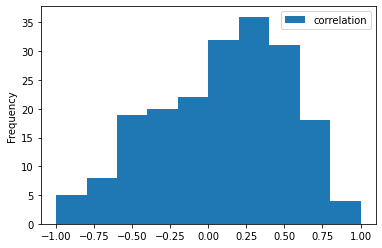

In [228]:
x.plot.hist()

In [181]:
def calculate_correlation_quarter(user_session_data):
    expenses=[]
    for quarter in range (user_session_data['timestamp_quarter'].min(), user_session_data['timestamp_quarter'].max()):
        d = {
            "quarter": quarter,
            "expenses": user_session_data[(user_session_data['timestamp_quarter'] == quarter) & (user_session_data['event_type'] == "BUY_PRODUCT")]['price'].sum()}
        expenses.append(d)

    df = pd.DataFrame(data=expenses)
    # df = df.set_index('quarter')
    if not (df.empty or (len(df) == 1)):
        print(get_user_id_from_session(user_session_data),df.corr()['expenses']['quarter'])
        return {'correlation': df.corr()['expenses']['quarter']}
    else:
        return {'correlation': 0}

In [189]:
enriched_sessions_data[enriched_sessions_data['user_id'] == 134]['timestamp_quarter'].max()

4

<AxesSubplot:xlabel='month'>

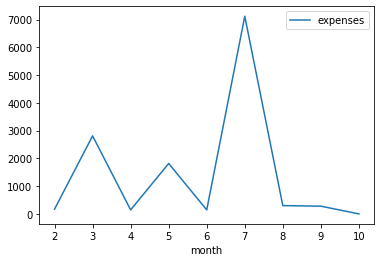

In [234]:
user_session_data = enriched_sessions_data[enriched_sessions_data['user_id'] == 105]
expenses=[]
for month in range (user_session_data['timestamp_month'].min(), user_session_data['timestamp_month'].max()):
    d = {
        "month": month,
        "expenses": user_session_data[(user_session_data['timestamp_month'] == month) & (user_session_data['event_type'] == "BUY_PRODUCT")]['price'].sum()}
    expenses.append(d)

df = pd.DataFrame(data=expenses)
df = df.set_index('month')
df.plot()
# calculate_correlation_quarter(user_session_data)

In [163]:
user_session_data[(user_session_data['timestamp_week'] == 30) & (user_session_data['event_type'] == "BUY_PRODUCT")]['price'].sum()

0.0

# Ekstrakcja userów

In [60]:
def get_user_information(user_session_data):
    d = {
        'user_id': [get_user_id_from_session(user_session_data)],
        'expenses': [user_session_data[user_session_data['event_type'] == "BUY_PRODUCT"]['price'].sum()],
        'products_bought': [len(user_session_data[user_session_data['event_type'] == "BUY_PRODUCT"])],
        'events_number': [len(user_session_data)],
        'sessions_number': [len(user_session_data['session_id'].unique())],
        'average_discount': [user_session_data['offered_discount'].mean()],
        'average_discount_on_bought': [user_session_data[user_session_data['event_type'] == "BUY_PRODUCT"]['offered_discount'].mean()]
    }
    df = pd.DataFrame(data=d)
    return df.set_index('user_id')

In [61]:
def extract_users_data(sessions_data, users_data, products_data):
    enriched_sessions_data = pd.merge(sessions_data, products_data, on="product_id").sort_values(by=['timestamp'])
    extracted_users = []
    for user_id in enriched_sessions_data['user_id'].unique():
        extracted_users.append(get_user_information(enriched_sessions_data[enriched_sessions_data['user_id'] == user_id]))
    enriched_users_data = pd.concat(extracted_users)
    return pd.merge(enriched_users_data, users_data, on="user_id").drop(columns=['name', 'street'])
    # print(len(sessions_data.user_id.unique()))

### Warsztat sesji użytkownika

In [45]:
enriched_sessions_data = pd.merge(sessions_data, products_data, on="product_id").sort_values(by=['timestamp'])
user_session_data = enriched_sessions_data[enriched_sessions_data['user_id'] == 137]
user_session_data

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,timestamp_month,product_name,category_path,price
16718,1535,2021-06-24 20:30:32,137,1048,VIEW_PRODUCT,15,NaN,6,Gra o tron (PC),Gry i konsole;Gry komputerowe,63.49
3600,1535,2021-06-24 20:32:27,137,1050,VIEW_PRODUCT,15,NaN,6,Bioshock 2 (PC),Gry i konsole;Gry komputerowe,37.90
5232,1535,2021-06-24 20:37:12,137,1054,VIEW_PRODUCT,15,NaN,6,Call of Duty 2 (PC),Gry i konsole;Gry komputerowe,32.99
16991,1535,2021-06-24 20:41:01,137,1056,VIEW_PRODUCT,15,NaN,6,Call of Duty Black Ops (PC),Gry i konsole;Gry komputerowe,29.99
4429,1535,2021-06-24 20:41:12,137,1053,VIEW_PRODUCT,15,NaN,6,Anno 2070 (PC),Gry i konsole;Gry komputerowe,42.90
...,...,...,...,...,...,...,...,...,...,...,...
4891,1547,2021-12-07 04:38:35,137,1051,VIEW_PRODUCT,0,NaN,12,Spec Ops The Line (PC),Gry i konsole;Gry komputerowe,76.90
4061,1547,2021-12-07 04:43:20,137,1052,VIEW_PRODUCT,0,NaN,12,Duke Nukem Forever (PC),Gry i konsole;Gry komputerowe,78.90
4062,1547,2021-12-07 04:46:16,137,1052,BUY_PRODUCT,0,20785.0,12,Duke Nukem Forever (PC),Gry i konsole;Gry komputerowe,78.90
19441,1521,2021-12-07 09:16:56,137,1283,VIEW_PRODUCT,20,NaN,12,Okulary 3D PHILIPS PTA436/00,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99


In [56]:
user_bought_products = user_session_data[user_session_data['event_type'] == "BUY_PRODUCT"]

In [59]:
user_session_data['offered_discount'].mean()

10.69832402234637

In [58]:
user_session_data[user_session_data['event_type'] == "BUY_PRODUCT"]['offered_discount'].mean()

12.285714285714286

In [62]:
extracted_train = extract_users_data(train_data, users_data, products_data).sort_values(['user_id'])

In [63]:
extracted_train

,user_id,expenses,products_bought,events_number,sessions_number,average_discount,average_discount_on_bought,city
37,102,5459.63,11,75,26,9.400000,8.636364,Wrocław
138,103,11687.52,18,98,26,8.622449,8.888889,Warszawa
43,104,16008.62,26,139,44,10.683453,9.230769,Gdynia
31,105,12793.27,17,93,28,9.354839,9.705882,Gdynia
163,106,1530.64,8,81,23,9.567901,6.250000,Wrocław
...,...,...,...,...,...,...,...,...
161,297,7085.01,10,72,17,10.486111,8.500000,Kraków
175,298,5626.49,11,85,17,8.941176,6.818182,Warszawa
123,299,7527.25,11,102,30,8.284314,8.636364,Gdynia
82,300,10103.68,5,34,16,12.941176,13.000000,Radom


In [64]:
extracted_test = extract_users_data(test_data, users_data, products_data).sort_values(['user_id'])

In [65]:
extracted_test

,user_id,expenses,products_bought,events_number,sessions_number,average_discount,average_discount_on_bought,city
179,102,283.99,2,30,7,3.000000,7.500000,Wrocław
109,103,7876.63,13,85,21,9.764706,8.846154,Warszawa
10,104,11583.09,12,73,22,11.164384,10.000000,Gdynia
146,105,49.99,1,22,4,5.681818,5.000000,Gdynia
71,106,10812.20,8,53,13,9.905660,11.250000,Wrocław
...,...,...,...,...,...,...,...,...
58,297,2613.29,8,28,12,7.678571,11.250000,Kraków
93,298,8486.84,10,58,21,10.431034,11.000000,Warszawa
101,299,3971.49,8,59,18,7.966102,9.375000,Gdynia
85,300,3741.12,6,43,10,11.046512,10.000000,Radom


In [66]:
desired_output = extracted_test[['user_id', 'expenses']].set_index('user_id')
desired_output = desired_output.rename(columns = {'expenses':'future_expenses'})

In [67]:
wichtige_tabelle = pd.merge(extracted_train, desired_output, on="user_id").sort_values(by=['user_id'])
wichtige_tabelle

,user_id,expenses,products_bought,events_number,sessions_number,average_discount,average_discount_on_bought,city,future_expenses
0,102,5459.63,11,75,26,9.400000,8.636364,Wrocław,283.99
1,103,11687.52,18,98,26,8.622449,8.888889,Warszawa,7876.63
2,104,16008.62,26,139,44,10.683453,9.230769,Gdynia,11583.09
3,105,12793.27,17,93,28,9.354839,9.705882,Gdynia,49.99
4,106,1530.64,8,81,23,9.567901,6.250000,Wrocław,10812.20
...,...,...,...,...,...,...,...,...,...
183,297,7085.01,10,72,17,10.486111,8.500000,Kraków,2613.29
184,298,5626.49,11,85,17,8.941176,6.818182,Warszawa,8486.84
185,299,7527.25,11,102,30,8.284314,8.636364,Gdynia,3971.49
186,300,10103.68,5,34,16,12.941176,13.000000,Radom,3741.12


In [68]:
wichtige_tabelle.corr()

,user_id,expenses,products_bought,events_number,sessions_number,average_discount,average_discount_on_bought,future_expenses
user_id,1.000000,-0.099681,-0.093624,-0.053508,-0.053445,-0.045261,-0.008318,0.009647
expenses,-0.099681,1.000000,0.831927,0.806947,0.794927,-0.075783,-0.000437,0.237832
products_bought,-0.093624,0.831927,1.000000,0.934341,0.922238,-0.134742,-0.048222,0.326851
events_number,-0.053508,0.806947,0.934341,1.000000,0.980018,-0.147244,-0.062267,0.324501
sessions_number,-0.053445,0.794927,0.922238,0.980018,1.000000,-0.142311,-0.048495,0.342022
average_discount,-0.045261,-0.075783,-0.134742,-0.147244,-0.142311,1.000000,0.663751,-0.004407
average_discount_on_bought,-0.008318,-0.000437,-0.048222,-0.062267,-0.048495,0.663751,1.000000,0.017732
future_expenses,0.009647,0.237832,0.326851,0.324501,0.342022,-0.004407,0.017732,1.000000


In [220]:
wichtige_tabelle['future_expenses_binrz'] = wichtige_tabelle['future_expenses'].apply(lambda b: 1 if b > 3000 else 0)

In [221]:
wichtige_tabelle

,user_id,expenses,products_bought,events_number,city,future_expenses,future_expenses_binrz
0,102,5459.63,11,75,Wrocław,283.99,0
1,103,11687.52,18,98,Warszawa,7876.63,1
2,104,16008.62,26,139,Gdynia,11583.09,1
3,105,12793.27,17,93,Gdynia,49.99,0
4,106,1530.64,8,81,Wrocław,10812.20,1
...,...,...,...,...,...,...,...
183,297,7085.01,10,72,Kraków,2613.29,0
184,298,5626.49,11,85,Warszawa,8486.84,1
185,299,7527.25,11,102,Gdynia,3971.49,1
186,300,10103.68,5,34,Radom,3741.12,1


In [222]:
wichtige_tabelle.corr()

,user_id,expenses,products_bought,events_number,future_expenses,future_expenses_binrz
user_id,1.000000,-0.099681,-0.093624,-0.053508,0.009647,0.019957
expenses,-0.099681,1.000000,0.831927,0.806947,0.237832,0.279846
products_bought,-0.093624,0.831927,1.000000,0.934341,0.326851,0.316860
events_number,-0.053508,0.806947,0.934341,1.000000,0.324501,0.328948
future_expenses,0.009647,0.237832,0.326851,0.324501,1.000000,0.752570
future_expenses_binrz,0.019957,0.279846,0.316860,0.328948,0.752570,1.000000


Przykłady użycia i resztki z developmentu

In [119]:
get_user_information(user_session_data)

,expenses,products_bought,events_number
user_id,,,
137,23662.84,35,179


In [120]:
extract_users_data(sessions_data, users_data, products_data)

,user_id,expenses,products_bought,events_number,city
0,139,23400.85,49,256,Kraków
1,242,44677.14,60,331,Radom
2,108,16312.03,23,130,Radom
3,143,7273.05,16,86,Kraków
4,140,33412.55,44,318,Poznań
...,...,...,...,...,...
195,289,0.00,0,7,Warszawa
196,225,109.00,1,5,Warszawa
197,152,0.00,0,5,Poznań
198,162,78.96,2,6,Szczecin


# Archiwum
Funkcje niegdyś przydatne, teraz już niepotrzebne, ale szkoda wyrzucać

In [106]:
def find_returned_users(extracted_sessions_data):
    user_counts = extracted_sessions_data['user_id'].value_counts()
    return user_counts[user_counts>=2].index

In [107]:
def find_never_returned_users(extracted_sessions_data):
    user_counts = extracted_sessions_data['user_id'].value_counts()
    return user_counts[user_counts<2].index